<p style="font-size:36px;text-align:center"> <b>CYCLE GAN</b> </p>

<p style="font-size:36px;text-align:center"> <img src="https://junyanz.github.io/CycleGAN/images/teaser_high_res.jpg"> </p>

The Cycle Generative Adversarial Network, or CycleGAN, is an approach to training a deep convolutional neural network for image-to-image translation tasks.The original paper for the same can be found [here](https://arxiv.org/abs/1703.10593). 

Unlike other GAN models for image translation, the CycleGAN does not require a dataset of paired images. For example, if we are interested in translating photographs of oranges to apples, we do not require a training dataset of oranges that have been manually converted to apples. This allows the development of a translation model on problems where training datasets may not exist, such as translating paintings to photographs.

In this notebook CycleGAN is used for converting photographs to ukiyoe paintings. From [wikipedia](https://en.wikipedia.org/wiki/Ukiyo-e), 'Ukiyoe is a genre of Japanese art which flourished from the 17th through 19th centuries. Its artists produced woodblock prints and paintings of such subjects as female beauties; kabuki actors and sumo wrestlers; scenes from history and folk tales; travel scenes and landscapes; flora and fauna; and erotica. The term ukiyoe translates as "pictures of the floating world".'

# Importing the required libraries.

In [7]:
from __future__ import print_function, unicode_literals, absolute_import, division
import os
import random
import progressbar
from urllib.request import urlretrieve
import zipfile
import argparse
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import time
print(tf.__version__)

2.0.0


# Using python script for downloading and unzipping the required data for the case study.

In [0]:
#reference:- https://github.com/leimao/Image_Converter_CycleGAN/blob/master/download.py
pbar = None

def progress_bar(block_num, block_size, total_size):
    global pbar
    if pbar is None:

        # pbar = progressbar.ProgressBar(maxval = total_size)
        # Customized progress bar
        widgets = [progressbar.Percentage(), ' ', progressbar.Bar(marker = '>', left = '[', right = ']'), ' ', progressbar.ETA(), ' ', progressbar.FileTransferSpeed()] 
        pbar = progressbar.ProgressBar(widgets = widgets, maxval = total_size).start()
    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

def maybe_download(filename, url, destination_dir, expected_bytes = None, force = False):

    filepath = os.path.join(destination_dir, filename)

    if force or not os.path.exists(filepath):
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        print('Attempting to download: ' + filename)
        filepath, _ = urlretrieve(url, filepath, reporthook = progress_bar)
        print('Download complete!')

    statinfo = os.stat(filepath)

    if expected_bytes != None:
        if statinfo.st_size == expected_bytes:
            print('Found and verified: ' + filename)
        else:
            raise Exception('Failed to verify: ' + filename + '. Can you get to it with a browser?')
    else:
        print('Found: ' + filename)
        print('The size of the file: ' + str(statinfo.st_size))

    return filepath


def maybe_unzip(zip_filepath, destination_dir, force = False):

    print('Extracting zip file: ' + os.path.split(zip_filepath)[-1])
    with zipfile.ZipFile(zip_filepath) as zf:
        zf.extractall(destination_dir)
    print("Extraction complete!")


def download_dataset(download_dir = './', data_dir = './'):

    url_prefix = 'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/'
    data_files = ['ukiyoe2photo.zip']

    for data_file in data_files:
        url = url_prefix + data_file
        dataset_filepath = maybe_download(filename = data_file, url = url, destination_dir = download_dir, force = False)
        destination_dir = data_dir
        maybe_unzip(zip_filepath = dataset_filepath, destination_dir = destination_dir, force = False)
    os.remove('ukiyoe2photo.zip')

In [4]:
download_dataset()

Attempting to download: ukiyoe2photo.zip


100% [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] Time:  0:00:14  19.0 MiB/s


Download complete!
Found: ukiyoe2photo.zip
The size of the file: 292946532
Extracting zip file: ukiyoe2photo.zip
Extraction complete!


# Defining various utility functions for preprocessing the images and generating images during training and testing phase.

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), random jittering and mirroring are the techniques applied to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

#reference:-https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/r2/tutorials/generative/cyclegan.ipynb
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = tf.io.read_file(image)
  image = tf.image.decode_jpeg(image, channels=3)
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = tf.io.read_file(image)
  image = tf.image.decode_image(image, channels=3)
  image = normalize(image)
  return image

#Utility function for generating images during the training phase.
def generate_images_train(model_A, test_input_A, model_B, test_input_B, epoch):
  prediction_A = model_A(test_input_A)
  prediction_B = model_B(test_input_B)
  
  plt.figure(figsize=(12, 12))
  display_list_A = [test_input_A[0], prediction_A[0]]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list_A[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('generated(A->B)_{}.png'.format(epoch+1))
  plt.close()

  plt.figure(figsize=(12, 12))
  display_list_B = [test_input_B[0], prediction_B[0]]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list_B[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('generated(B->A)_{}.png'.format(epoch+1))
  plt.close()

  os.rename('./generated(A->B)_{}.png'.format(epoch+1), './pictures/generated(A->B)_{}.png'.format(epoch+1))
  os.rename('./generated(B->A)_{}.png'.format(epoch+1), './pictures/generated(B->A)_{}.png'.format(epoch+1))


#Utility function for generating images during testing phase.
def generate_images_test(model, test_input):
  prediction = model(test_input)
  
  plt.figure(figsize=(12, 12))
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  plt.close()

# Utility function for normalization.

Unlike many deep learning models, the [CycleGAN](https://arxiv.org/abs/1703.10593) discriminator uses InstanceNormalization instead of BatchNormalization. It is a very simple type of normalization and involves standardizing (e.g. scaling to a standard Gaussian) the values on each output feature map, rather than across features in a batch.

In [0]:
def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return tfa.layers.LayerNormalization

# Defining a class for Reflective Padding.

The original [paper](https://arxiv.org/abs/1703.10593) used reflective padding in it's generator network. Reflection padding avoid some artifacts on the boundary, as noted in the paper. 

In [0]:
#reference:-https://stackoverflow.com/questions/50677544/reflection-padding-conv2d
class Pad(keras.layers.Layer):

    def __init__(self, paddings, mode='CONSTANT', constant_values=0, **kwargs):
        super(Pad, self).__init__(**kwargs)
        self.paddings = paddings
        self.mode = mode
        self.constant_values = constant_values

    def call(self, inputs):
        return tf.pad(inputs, self.paddings, mode=self.mode, constant_values=self.constant_values)

# Defining the generator network for the model.

The generator is an encoder-decoder model architecture. The model takes a source image (e.g. real image) and generates a target image (e.g. ukiyoe). It does this by first downsampling or encoding the input image down to a bottleneck layer, then interpreting the encoding with a number of residual blocks which uses skip connections, followed by a series of layers that upsample or decode the representation to the size of the output image.

In [0]:
def ResnetGenerator(input_shape=(256, 256, 3), output_channels=3, dim=64,
                    n_downsamplings=2, n_blocks=9, norm='instance_norm'):
    
    Norm = _get_norm_layer(norm)

    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = Pad([[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')(h)
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = keras.layers.ReLU()(h)

        h = Pad([[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')(h)
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    
    h = inputs = keras.Input(shape=input_shape)

    
    h = Pad([[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')(h)
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = keras.layers.ReLU()(h)

    
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = keras.layers.ReLU()(h)

    
    for _ in range(n_blocks):
        h = _residual_block(h)

    
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = keras.layers.ReLU()(h)

    
    h = Pad([[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')(h)
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)


# Defining the discriminator network for the model.

The function below implements the 70×70 PatchGAN discriminator model as per the design of the model in the paper. The model takes a 256×256 sized image as input and outputs a patch of predictions. The receptive fiels can be calculated [here](https://fomoro.com/research/article/receptive-field-calculator#)

In [0]:
def ConvDiscriminator(input_shape=(256, 256, 3), dim=64, n_downsamplings=3, norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)

    
    h = inputs = keras.Input(shape=input_shape)

    
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same')(h)
    h = keras.layers.LeakyReLU(alpha=0.2)(h)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = keras.layers.LeakyReLU(alpha=0.2)(h)

    
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = keras.layers.LeakyReLU(alpha=0.2)(h)

    
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same')(h)

    return keras.Model(inputs=inputs, outputs=h)

# Defining a class for decaying the learning rate as the training progresses.

The model is trained for 200 epochs in total. The learning rate is kept same for the first 100 epochs and linearly decay the rate to zero over the next 100 epochs. See the appendix of the [paper](https://arxiv.org/abs/1703.10593) for more details.

In [0]:
class LinearDecay(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

# Looking at the structure of the generator and discriminator.

In [0]:
generator=ResnetGenerator()
discriminator=ConvDiscriminator()

In [0]:
print(generator.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
pad (Pad)                       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        pad[0][0]                        
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
print(discriminator.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_23 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 256)       5242

# Defining the input pipeline for training the model.

The pipeline first takes number of images which are equal to batch size, preprocesses them and finally feeds them to the model. It also prefetches the number of images mentioned in batch size before every training epoch so that the training process could be fasten. More about input pipeline for image data can be found [here](https://www.tensorflow.org/tutorials/load_data/images).

In [0]:
os.mkdir('./pictures')
PATH_train_A='ukiyoe2photo/trainA/'
PATH_train_B='ukiyoe2photo/trainB/'
EPOCHS = 200
trainA_size = len(os.listdir(PATH_train_A))
trainB_size = len(os.listdir(PATH_train_B))
batch_size=1 #Change if multi gpu
len_dataset = max(trainA_size, trainB_size) // batch_size

In [0]:
print('Building data input pipeline.....')
train_A=tf.data.Dataset.list_files(PATH_train_A+'*.jpg')
train_A=train_A.map(preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(trainA_size).batch(batch_size)
train_A=train_A.prefetch(batch_size)

train_B=tf.data.Dataset.list_files(PATH_train_B+'*.jpg')
train_B=train_B.map(preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(trainB_size).batch(batch_size)
train_B=train_B.prefetch(batch_size)
print('Done!!!')

Building data input pipeline.....
Done!!!


# Looking at the sample images from the dataset.

In [0]:
sample_ukiyoe = next(iter(train_A))
sample_photo = next(iter(train_B))

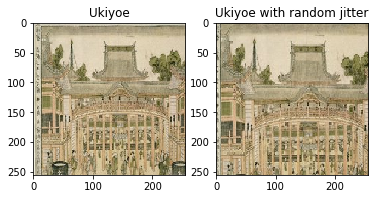

In [0]:
#reference:- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
plt.subplot(121)
plt.title('Ukiyoe')
plt.imshow(sample_ukiyoe[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Ukiyoe with random jitter')
plt.imshow(random_jitter(sample_ukiyoe[0]) * 0.5 + 0.5)

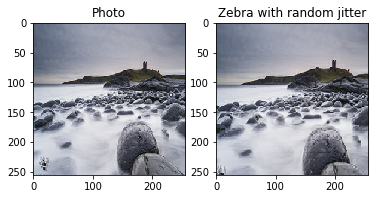

In [0]:
#reference:- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
 plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

# Feeding the images above to the untrained generator and discriminator to see how it works.

In [0]:
generator_g=ResnetGenerator()
generator_f=ResnetGenerator()

discriminator_x=ConvDiscriminator()
discriminator_y=ConvDiscriminator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


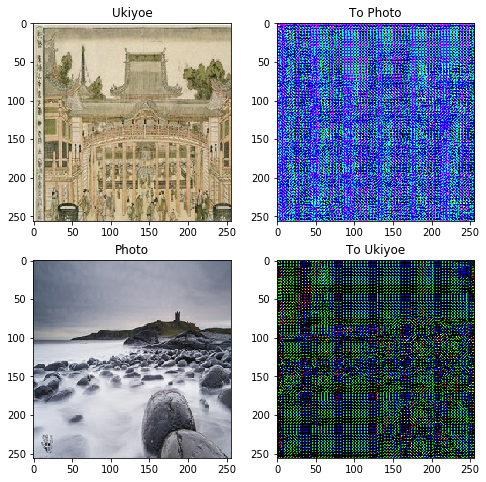

In [0]:
#reference:- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
to_photo = generator_g(sample_ukiyoe)
to_ukiyoe = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_ukiyoe, to_photo, sample_photo, to_ukiyoe]
title = ['Ukiyoe', 'To Photo', 'Photo', 'To Ukiyoe']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

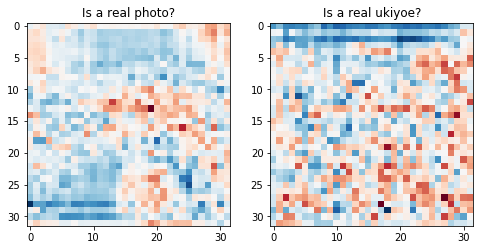

In [0]:
# reference:- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real photo?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real ukiyoe?')
plt.imshow(discriminator_x(sample_ukiyoe)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Defining the loss functions.

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/generative/images/cycle_loss.png)

As shown, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [0]:
#reference:-https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

#Initialize the optimizers for all the generators and the discriminators.
G_lr_scheduler = LinearDecay(0.0002, EPOCHS * len_dataset, 100 * len_dataset)
D_lr_scheduler = LinearDecay(0.0002, EPOCHS * len_dataset, 100 * len_dataset)

generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=0.5)

# Creating checkpoints to save the model.

In [0]:
#reference:- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
checkpoint_path = "./checkpoints/train"
checkpoint_path_final_model = "./checkpoint/final_model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_final = tf.train.Checkpoint(generator_g=generator_g,
                                 generator_f=generator_f)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt_manager_final_model = tf.train.CheckpointManager(ckpt_final, checkpoint_path_final_model, max_to_keep=1)


if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


# Defining the training step.

The tf.function decorator in code below uses the tensorflow 2.0 Autograph functionality. AutoGraph is one of the most exciting new features of Tensorflow 2.0: it allows transforming a subset of Python syntax into its portable, high-performance and language agnostic graph representation bridging the gap between Tensorflow 1.x and the 2.0 release based on eager execution. Even without this decorator everything would run fine as expected but we wouldn't get the benefit of the graph that tensorflow uses to boost the training time. More about tf.function can be found [here](https://www.tensorflow.org/tutorials/customization/performance).

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [0]:
#reference:-https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x)
    cycled_x = generator_f(fake_y)

    fake_x = generator_f(real_y)
    cycled_y = generator_g(fake_x)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x)
    same_y = generator_g(real_y)

    disc_real_x = discriminator_x(real_x)
    disc_real_y = discriminator_y(real_y)

    disc_fake_x = discriminator_x(fake_x)
    disc_fake_y = discriminator_y(fake_y)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

# Starting the training process.

In [0]:
#reference:-https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
print("Training loop started\n")
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_A, train_B)):
        train_step(image_x, image_y)
        if n%10==0:
            print ('.', end='')
        n+=1
    print('\n')
    generate_images_train(generator_g, sample_ukiyoe, generator_f, sample_photo, epoch)
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    if (epoch+1)==200:
        ckpt_save_path=ckpt_manager_final_model.save()
        print("Final model saved at {}".format(ckpt_save_path)) 

    print ('Time taken for epoch {} is {} minutes\n'.format(epoch + 1, (int(time.time()-start)/60)))
print("Done!!!\n")

Training loop started

.........................................................

Time taken for epoch 156 is 8.616666666666667 minutes

.........................................................

Time taken for epoch 157 is 7.783333333333333 minutes

.........................................................

Time taken for epoch 158 is 7.783333333333333 minutes

.........................................................

Time taken for epoch 159 is 7.783333333333333 minutes

.........................................................

Saving checkpoint for epoch 160 at ./checkpoints/train/ckpt-32
Time taken for epoch 160 is 7.816666666666666 minutes

.........................................................

Time taken for epoch 161 is 7.8 minutes

.........................................................

Time taken for epoch 162 is 7.8 minutes

.........................................................

Time taken for epoch 163 is 7.8 minutes

............................................

# Testing the trained model by suing the testing data.

Latest checkpoint restored!!


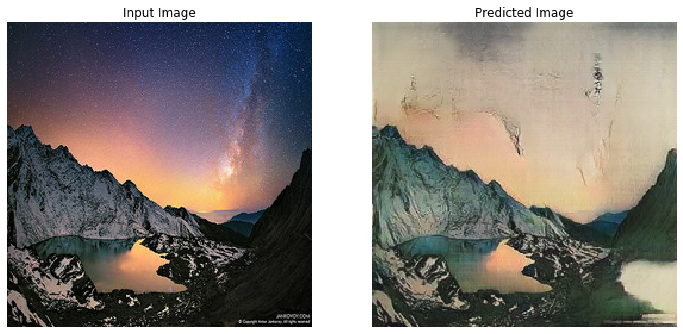

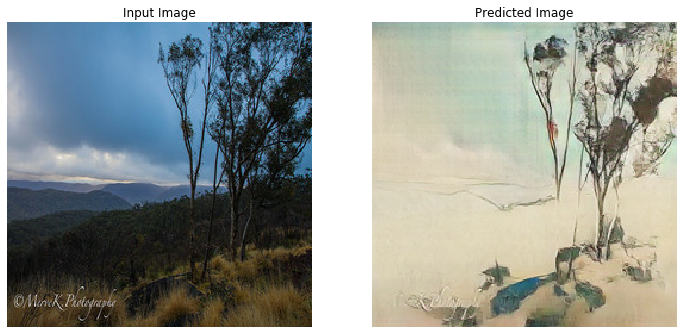

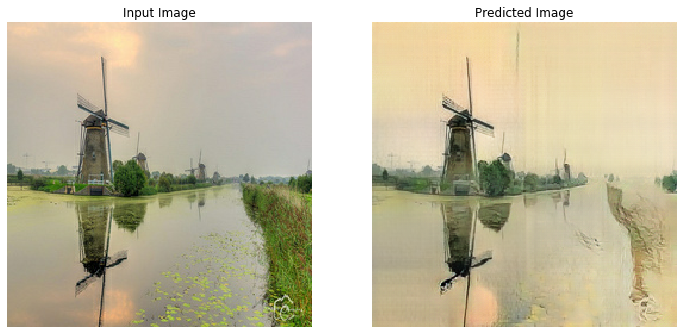

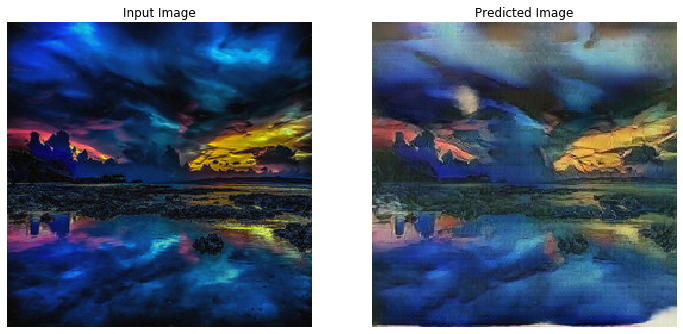

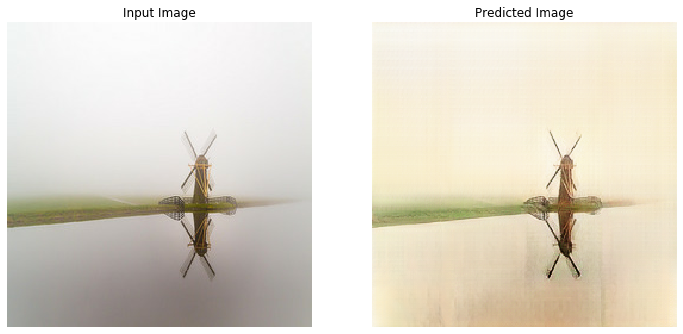

In [18]:
tf.get_logger().setLevel('WARNING')

PATH_test_B='ukiyoe2photo/testB/'
batch_size=1
testB_size = len(os.listdir(PATH_test_B))

test_B=tf.data.Dataset.list_files(PATH_test_B+'*.jpg')
test_B=test_B.map(preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(testB_size).batch(batch_size)
test_B=test_B.prefetch(batch_size)

generator_f = ResnetGenerator()

checkpoint_path_final_model = "./checkpoint/final_model"


ckpt = tf.train.Checkpoint(generator_f=generator_f)

ckpt_manager_final_model = tf.train.CheckpointManager(ckpt, checkpoint_path_final_model, max_to_keep=1)

if ckpt_manager_final_model.latest_checkpoint:
  ckpt.restore(ckpt_manager_final_model.latest_checkpoint)
  print ('Latest checkpoint restored!!')
  for inp in test_B.take(5):
    generate_images_test(generator_f, inp)

else:
  print("Download the pretrained model from \'https://drive.google.com/drive/folders/1-tKDLeaRJ_5Kn3gkWAvZh6FcgeNK8mWV?usp=sharing' else train the model from scratch.")

# Try the trained model on your own image.

Provide the path to the original image: /content/pexels-photo-592077.jpeg
Latest checkpoint restored!!


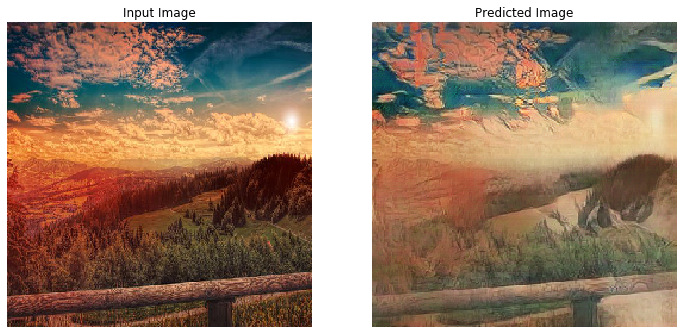

In [20]:
input_img=str(input('Provide the path to the original image: '))

image = load_img(input_img, target_size=(256, 256))
image = img_to_array(image)
image = normalize(image)
image = image[tf.newaxis, ...]

generator_f=ResnetGenerator()
generator_g=ResnetGenerator()

checkpoint_path_final_model = "./checkpoint/final_model"


ckpt = tf.train.Checkpoint(generator_f=generator_f,
                           generator_g=generator_g)

ckpt_manager_final_model = tf.train.CheckpointManager(ckpt, checkpoint_path_final_model, max_to_keep=1)

if ckpt_manager_final_model.latest_checkpoint:
  ckpt.restore(ckpt_manager_final_model.latest_checkpoint)
  print ('Latest checkpoint restored!!')
  generate_images_test(generator_f, image)

else:
  print("Download the pretrained model from \'https://drive.google.com/drive/folders/1-tKDLeaRJ_5Kn3gkWAvZh6FcgeNK8mWV?usp=sharing' else train the model from scratch.")

# Conclusion

In this notebook CycleGAN was used for image-to-image transition for converting real images to ukiyoe style painting. The model architecture was comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B).

* Generator-A -> Domain-A
* Generator-B -> Domain-B

The generator models performed image translation, meaning that the image generation process was conditional on an input image, specifically an image from the other domain. Generator-A took an image from Domain-B as input and Generator-B took an image from Domain-A as input.

* Domain-B -> Generator-A -> Domain-A
* Domain-A -> Generator-B -> Domain-B

Each generator had a corresponding discriminator model. The first discriminator model (Discriminator-A) took real images from Domain-A and generated images from Generator-A and predicted whether they are real or fake. The second discriminator model (Discriminator-B) took real images from Domain-B and generated images from Generator-B and predicted whether they are real or fake.

* Domain-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Discriminator-B -> [Real/Fake]
* Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]

The discriminator and generator models were trained in an adversarial zero-sum process, like normal GAN models. The generators learned to better fool the discriminators and the discriminator learned to better detect fake images. Together, the models found the required equilibrium during the training process.

Additionally, the generator models were regularized to not just create new images in the target domain, but instead translate more reconstructed versions of the input images from the source domain. This was achieved by using generated images as input to the corresponding generator model and comparing the output image to the original images. Passing an image through both generators is called a cycle. Together, each pair of generator models were trained to better reproduce the original source image, referred to as cycle consistency.

* Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
* Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A

Finally there was one further element to the architecture, referred to as the identity mapping. This is where a generator was provided with images as input from the target domain and was expected to generate the same image without change. 

* Domain-A -> Generator-A -> Domain-A
* Domain-B -> Generator-B -> Domain-B